<a href="https://colab.research.google.com/github/carlosdcorona/PySpark/blob/main/PCAwithpySpark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 04: PCA with Spark

### Bernardo Samuel Salazar de Hoyos A00825722
### Carlos Daniel Corona Cortez A01656002
### Sebastian Andres Saldaña Cárdenas A01570274
### Sergio Noé Torres Rodríguez A00825706
### Raúl V. Ramírez Velarde
### October 31, 2022

## Load pySpark and Libraries to use

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.1.3/spark-3.1.3-bin-hadoop2.7.tgz
!tar xf spark-3.1.3-bin-hadoop2.7.tgz
!pip install -q findspark

In [ ]:
#All imports
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.3-bin-hadoop2.7"

In [ ]:
import findspark
findspark.init()

from google.colab import drive
drive.mount("/content/drive")

from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf,SQLContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import round,max,udf

from numpy import sqrt,zeros,c_,amax,max

from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import PCA

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

Mounted at /content/drive


In [ ]:
#Small printing
%precision 2
np.set_printoptions(precision=2)

# Functions

## Functions Pyspark

In [ ]:
def label_encoder(df,inputColumn,outputcolname):
  le = StringIndexer(inputCols = inputColumn, outputCols = outputcolname)
  le_fit = le.fit(df)
  return le_fit.transform(df)

In [ ]:
def vector_assembling(data,cols,colsname):
  assembler = VectorAssembler(inputCols = cols, outputCol = colsname)
  return assembler.transform(data)

In [ ]:
def standard_scaling(df,inputcol,outputcol):
  scaler = StandardScaler(inputCol = inputcol, outputCol = outputcol, withStd = True, withMean = True)
  scalerModel = scaler.fit(df)
  return scalerModel.transform(df)

## Functions PCA

In [ ]:
def apply_pca(df,colinp,colout,num):
  pca = PCA(k=num,inputCol=colinp,outputCol=colout)
  model_pca = pca.fit(df)
  return model_pca

In [ ]:
def scree_plot(model_pca):
  expVar = model_pca.explainedVariance
  plt.rcParams["figure.figsize"] = (12,9)

  plt.plot(expVar, marker = 'h', color = 'g')
  plt.ylabel("Eigenvalue")
  plt.xlabel("Component Number")
  plt.title("Scree Plot",fontsize = 20)
  print(np.round(100.00*expVar.toArray(),4))

  plt.show()

In [ ]:
def graph_ncomps_pca(model,num,var_des):
  plt.rcParams["figure.figsize"] = (12,9)

  fig, ax = plt.subplots()
  x_plot = np.arange(1,num+1,step=1)
  y_plot = np.cumsum(model.explainedVariance)

  plt.ylim(0.0,1.05)
  plt.plot(x_plot,y_plot,marker = 'h', linestyle = 'dashdot', color = 'g')

  plt.ylabel("Cummulative Variance")
  plt.xlabel("Number of components")
  plt.xticks(np.arange(0,num+1,step=1))
  plt.title(f"Variance of each eigenvector to explain desired variance: {var_des*100}%", fontsize = 20)

  plt.axhline(y = var_des, color = 'r', linestyle = 'solid')
  plt.text(0.5,0.85, f"{var_des*100}% cut-off threshold", color = 'r', fontsize = 14)

  ax.grid(axis = 'x')

  print([(x_plot[i], y_plot[i]) for i in range(len(x_plot))])
  plt.show()

In [ ]:
def make_table(model_pca,data,coldata,dfcols):
  Q = model_pca.pc.toArray()
  numcol = len(dfcols)
  s = numcol * model_pca.explainedVariance.toArray()
  s = np.sqrt(s)
  F = model_pca.transform(data).select(coldata)
  L = zeros(shape = (Q.shape))
  for col in range(0,len(s)-1):
      L[:,col] = Q[:,col] * s[col]
  COS2 = L**2
  pd.set_option('display.float_format', lambda x: '%.4f' % x)
  return pd.DataFrame(COS2, columns = ['PC' + str(i) for i in range(1,COS2.shape[1]+1)], index = dfcols), F, L, s

In [ ]:
def graph_circle_pca(model_pca,F,L,s,pc1,pc2,colpcs,col_df,obj_label):
  dicto_pcas = {}
  for i, k in enumerate(colpcs):
    dicto_pcas[k] = i

  ipc1 = dicto_pcas[pc1]
  ipc2 = dicto_pcas[pc2]

  colname = F.columns[0]
  dfx = F.rdd.map(lambda x:[float(y) for y in x[colname]]).toDF(colpcs)
  Scores = dfx.toPandas().to_numpy()

  fig = plt.figure()
  ax = fig.add_subplot(1,1,1)
  plt.grid()
  plt.axis([-1,1,-1,1])

  circ = plt.Circle((0,0), radius = 1, color = 'g', fill = False)
  ax.add_patch(circ)
  ax.set_aspect('equal')

  plt.scatter(L[:,ipc1],L[:,ipc2],s=30)
  plt.scatter(Scores[:,ipc1],Scores[:,ipc2],s=30)

  for row in range(0,len(s)):
    plt.plot([0, L[row,ipc1]], [0,L[row,ipc2]], linewidth = 3, label = 'X2')

  for row in range(0,len(s)):
    if col_df[row] == obj_label:
      ax.annotate(col_df[row], (L[row,ipc1]+random.uniform(-0.05,0.05),L[row,ipc2]+random.uniform(-0.05,0.05)),size = 25, color = 'r')
    else:
      ax.annotate(col_df[row], (L[row,ipc1]+random.uniform(-0.05,0.05),L[row,ipc2]+random.uniform(-0.05,0.05)),size = 20)

  plt.ylabel(f"F{pc2[-1]}: {100.00*np.round_(model_pca.explainedVariance[ipc2],4)}%", fontsize = 16)
  plt.xlabel(f"F{pc1[-1]}: {100.00*np.round_(model_pca.explainedVariance[ipc1],4)}%", fontsize = 16)
  plt.title('Correlation Plot', fontsize = 32)
  fig.set_size_inches(18.5, 10.5)
  plt.show()

# Operations

## Load Dataset and clean

In [ ]:
spark = SparkSession.builder.master("local[*]").getOrCreate()
path_csv="/content/drive/Shareddrives/Infra DS Equipo 4/Homework04/SpotifyTop2018_40_V2.csv"
spark_df = spark.read.option("delimiter",",").csv(path_csv,inferSchema=True, header =True)
spark_df.show(10)

+--------------------+------------+------+--------+-----------+------------+----------------+--------+-------+-------+-----------+--------------+
|                 _c0|danceability|energy|loudness|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|duration_ms|time_signature|
+--------------------+------------+------+--------+-----------+------------+----------------+--------+-------+-------+-----------+--------------+
|                Dura|       0.791| 0.848|  -3.456|     0.0506|       0.183|             0.0|   0.409|  0.828|   95.0|     200480|             4|
|           Plug_Walk|       0.876| 0.519|  -6.531|      0.143|       0.202|             0.0|   0.108|  0.158| 94.981|     175230|             4|
|             Silence|        0.52| 0.761|  -3.093|     0.0853|       0.256|         4.96E-6|    0.17|  0.286|141.971|     180823|             4|
|Solo_(feat._Demi_...|       0.737| 0.636|  -4.546|     0.0437|      0.0441|         6.66E-5|    0.35|  0.565|105.005|     2

In [ ]:
spark_df.dtypes

[('_c0', 'string'),
 ('danceability', 'double'),
 ('energy', 'double'),
 ('loudness', 'double'),
 ('speechiness', 'double'),
 ('acousticness', 'double'),
 ('instrumentalness', 'double'),
 ('liveness', 'double'),
 ('valence', 'double'),
 ('tempo', 'double'),
 ('duration_ms', 'int'),
 ('time_signature', 'int')]

In [ ]:
spark_df.toPandas().isnull().sum()

_c0                 0
danceability        0
energy              0
loudness            0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
time_signature      0
dtype: int64

## Make Pyspark and PCA operations

In [ ]:
input_cols = ["_c0"]
spark_df = label_encoder(spark_df,input_cols,[name + "_le" for name in input_cols])
spark_df = spark_df.select([name for name in spark_df.columns if name not in input_cols])
spark_df_va = vector_assembling(spark_df,spark_df.columns,"features_song")
spark_df_ss = standard_scaling(spark_df_va,"features_song","scaled_features_song")

In [ ]:
model_pca = apply_pca(spark_df_ss,"scaled_features_song","pca_features_song",10)

[19.44 16.87 13.39 10.82  9.75  7.37  5.93  5.42  4.61  2.55]


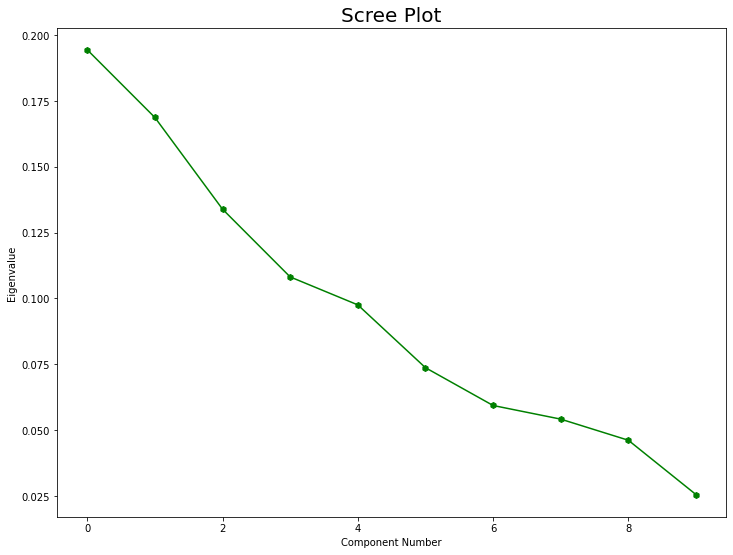

In [ ]:
scree_plot(model_pca)

There is not much inclination in the plot to identify the "elbow", indicating that the first principal components don't encompass much information from the other components, but we can consider 3 components as a good selection.

[(1, 0.19441914846377223), (2, 0.36313006540299864), (3, 0.4970221509149897), (4, 0.6051889940505943), (5, 0.7027355607784624), (6, 0.7764317496418421), (7, 0.835772150948839), (8, 0.8899316913899671), (9, 0.9360719540761471), (10, 0.9615851342213482)]


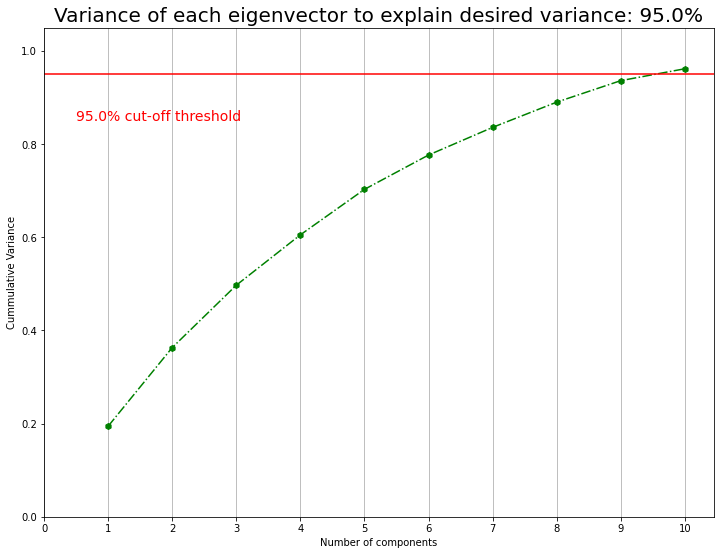

In [ ]:
graph_ncomps_pca(model_pca,10,0.95)

Looking at this plot, we note that each of the principal components explains a significant amount of variance.

In [ ]:
table, F, L, s = make_table(model_pca,spark_df_ss,"pca_features_song",spark_df.columns)

In [ ]:
table

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
danceability,0.2705,0.2530,0.0065,0.1061,0.0276,0.0303,0.2349,0.0011,0.0115,0.0000
energy,0.4790,0.3184,0.0007,0.0034,0.0050,0.0514,0.0231,0.0179,0.0060,0.0000
loudness,0.3131,0.3228,0.0809,0.0856,0.0256,0.0011,0.0005,0.0118,0.0112,0.0000
speechiness,0.0223,0.2214,0.1933,0.0928,0.0605,0.0776,0.0386,0.2563,0.0198,0.0000
acousticness,0.0010,0.2915,0.0000,0.2634,0.0646,0.2064,0.1257,0.0041,0.0071,0.0000
instrumentalness,0.0006,0.2003,0.2004,0.0040,0.1865,0.1699,0.0185,0.0240,0.1940,0.0000
liveness,0.0267,0.0003,0.2930,0.0044,0.4884,0.0271,0.0836,0.0144,0.0003,0.0000
valence,0.7105,0.0262,0.0513,0.0142,0.0147,0.0013,0.0124,0.0007,0.0061,0.0000
tempo,0.0300,0.0471,0.4632,0.2125,0.0025,0.0724,0.0344,0.0021,0.0589,0.0000
duration_ms,0.1489,0.1821,0.0495,0.1873,0.2476,0.0007,0.0046,0.0357,0.0651,0.0000


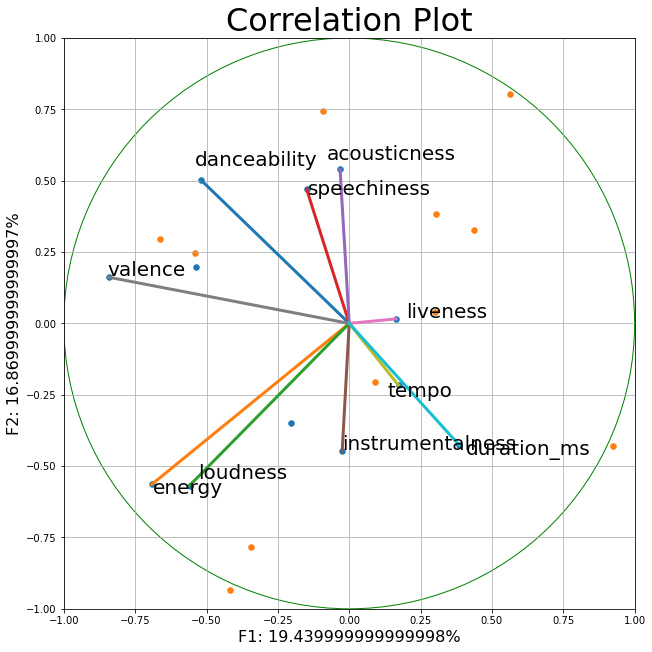

In [ ]:
graph_circle_pca(model_pca,F,L,s,'PC1','PC2',list(table.columns),list(table.index),'_c0_le')

In [ ]:
spark_df.columns

['danceability',
 'energy',
 'loudness',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'duration_ms',
 'time_signature',
 '_c0_le']

# **1. Which variables are correlated?**
## Looking at the correlation circle plot we can conclude that the variables tempo and duration_ms are positively correlated with each other, as are the variables speechiness with acousticness and energy with loudness.
## On the other hand, the variables that have a negative correlation are duration_ms and tempo with danceability, as well as acousticness with instrumentalness.

# **2. In the circle correlation plot, are there clusters formed? Can you explain the composition of the clusters if any?**
## The correlation circle plot of PC1 and PC2 shows the sample points that form some clusters, which are made up of groups of songs with similar attributes.



# **3. Apparently the songs In My Feelings, In My Mind, Havana, Candy Paint y HUMBLE, are not represented by PCs 1 and 2. Use PCs 1 and 3 and explain these songs.**


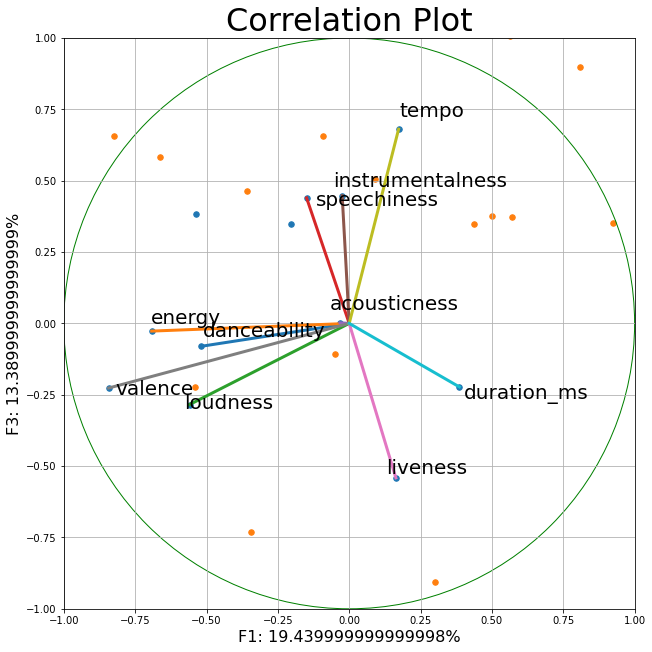

In [ ]:
graph_circle_pca(model_pca,F,L,s,'PC1','PC3',list(table.columns),list(table.index),'_c0_le')

## In this plane we observe a clear positive correlation in two groups, the first is between the variables energy, danceability, valence and loudness, and in the second group between speechiness, tempo, instrumentalness and acousticness, while liveness and speechiness are negatively correlated.
## Also, we notice that the variable time_signature does not appear in this plot, which may indicate that it has a 90° angle with respect to this plane (PC1 and PC3) which makes us not see the length of its eigenvector.

# **4. Can songs be grouped according to characteristics? If you are curious, use discoveR with k-mean algorithm and find out.**
## Yes, we can categorize songs by similar characteristics. This can be done by grouping them in clusters following the k-mean algorithm.